In [1]:
import numpy as np
import pickle
import time

from tqdm.auto import tqdm

from sklearn.linear_model import LogisticRegression
# from sklearn.calibration import CalibratedClassifierCV

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.metrics import log_loss, brier_score_loss, accuracy_score, confusion_matrix

import GPy
import optunity as opt
import sobol as sb

import scipy.stats as stats

import matplotlib.pyplot as plt

In [2]:
retrain = True

# Data

In [3]:
with open('../data/data_train.pt', 'rb') as file:
    X_train, y_train = pickle.load(file)

print(f'{X_train.shape = }')
print(f'{y_train.shape = }')

X_train.shape = (192638, 28)
y_train.shape = (192638, 2)


# Parameter Optimization

In [4]:
LogisticRegression_parameters = {
    'n_jobs': 8,                # use 8 cores
    'fit_intercept': False,     # data is scaled and centered, we can set fit_intercept=False
    'tol': 1e-5,                # more accurate than default
    'random_state': 20210927    # with the same random state
}

In [5]:
hyperparameter_search_space_boundaries = {
    'inverse_log_C': [-10, 8], # logarithm of the regularization coefficient
}

## Cross-Validation: Helper Functions

In [6]:
def get_mean_CV_Score(score_function, hyperparameters, y_label):
    assert y_label in ['hosp', 'death']
    y_index = 0 if y_label == 'hosp' else 1

    inverse_log_C, = hyperparameters

    kf = KFold(n_splits=5, shuffle=True, random_state=20210927)

    log_loss_list = np.empty(5, dtype=np.float64)

    for split_index, (fit_index, val_index) in enumerate(kf.split(X_train)):
        # create splits
        X_fit, X_val = X_train[fit_index], X_train[val_index]
        y_fit, y_val = y_train[fit_index], y_train[val_index]

        # scale features
        sc_X_fit = StandardScaler()
        X_fit_scaled = sc_X_fit.fit_transform(X_fit)
        X_val_scaled = sc_X_fit.transform(X_val)

        # create classifier
        lr = LogisticRegression(**LogisticRegression_parameters, C=1/np.exp(inverse_log_C))

        # fit
        lr.fit(X_fit_scaled, y_fit[:, y_index])

        # evaluate
        y_pred_proba = lr.predict_proba(X_val_scaled)
        log_loss_list[split_index] = score_function(y_val[:, y_index], y_pred_proba[:, 1])

    return np.mean(log_loss_list)

In [7]:
def expected_improvement(inverse_log_C, gp):
    # compute E(q) and Var(q)
    E_pred, Var_pred = gp.predict_noiseless(np.array([[inverse_log_C]]))

    # compute gamma with the STD(q)
    γ = (E_best - E_pred) / np.sqrt(Var_pred)

    # return Expected Improvement
    return np.sqrt(Var_pred) * (γ * stats.norm.cdf(γ) + stats.norm.pdf(γ))

In [8]:
def initialize_GP(n_samples, y_label):
    assert y_label in ['hosp', 'death']

    Q_init = np.empty((n_samples, 1))
    E_init = np.empty((n_samples, 1))

    for i in range(n_samples):
        Q_init[i, :] = sb.i4_sobol(1, i)[0] * (hyperparameter_search_space_boundaries['inverse_log_C'][1] - hyperparameter_search_space_boundaries['inverse_log_C'][0]) + hyperparameter_search_space_boundaries['inverse_log_C'][0]

    for i, (inverse_log_C,) in enumerate(tqdm(Q_init)):
        E_init[i, :] = get_mean_CV_Score(log_loss, (inverse_log_C,), y_label)

    return Q_init, E_init

## Run Optimization

In [9]:
initial_n_samples = 16
additional_n_samples = 64

In [10]:
GP, Q, E = {}, {}, {}
for y_label in ['hosp', 'death']:
    if retrain:
        print(f"Initializing GP for '{y_label}'...")
        time.sleep(0.3)
        Q[y_label], E[y_label] = initialize_GP(initial_n_samples, y_label)

        print('Training GP...')
        time.sleep(0.3)
        for k in tqdm(range(additional_n_samples)):

            # train Gaussian Process
            GP[y_label] = GPy.models.GPRegression(Q[y_label], E[y_label], kernel=GPy.kern.Matern52(1))
            GP[y_label].optimize(messages=False)

            # determine E_best (minimum value of E)
            E_best = np.min(E[y_label])

            # determine q_new (q with maximum expected improvement)
            optimizer_output = opt.maximize(
                lambda **kwargs: expected_improvement(gp=GP[y_label], **kwargs),
                inverse_log_C=hyperparameter_search_space_boundaries['inverse_log_C']
            )[0]
            q_new = np.array([optimizer_output['inverse_log_C']]).ravel()

            # add q_new to the training set Q
            Q[y_label] = np.vstack((Q[y_label], q_new))

            # add COR(tau, sigma, gamma) to E
            E[y_label] = np.vstack((E[y_label], get_mean_CV_Score(log_loss, q_new, y_label).reshape(-1, 1)))

        print('Completed Training')
        print('Storing Results...')
        with open(f'../results/LR_{y_label}.pt', 'wb') as file:
            pickle.dump((Q[y_label], E[y_label]), file)
        print('Stored Results...')

    else:
        print(f'Loading Results ({y_label})...')
        with open(f'../results/LR_{y_label}.pt', 'rb') as file:
            Q[y_label], E[y_label] = pickle.load(file)
        print(f'Loaded Results ({y_label})')

    GP[y_label] = GPy.models.GPRegression(Q[y_label], E[y_label], kernel=GPy.kern.Matern52(1))
    GP[y_label].optimize(messages=False);

Initializing GP for 'hosp'...


100%|██████████| 16/16 [03:06<00:00, 11.68s/it]


Training GP...


100%|██████████| 64/64 [12:46<00:00, 11.97s/it]


Completed Training
Storing Results...
Stored Results...
Initializing GP for 'death'...


100%|██████████| 16/16 [03:10<00:00, 11.92s/it]


Training GP...


100%|██████████| 64/64 [13:08<00:00, 12.31s/it]

Completed Training
Storing Results...
Stored Results...


## GP-Prediction

In [11]:
inverse_log_C_linspace = np.linspace(*np.array(hyperparameter_search_space_boundaries['inverse_log_C']) * np.array([1.1, 1.1]), 1000)

GP_predicted_log_loss_mean, GP_predicted_log_loss_std = {}, {}
for y_label in ['hosp', 'death']:
    GP_predicted_log_loss_mean[y_label], GP_predicted_log_loss_var = GP[y_label].predict_noiseless(inverse_log_C_linspace.reshape(-1, 1))
    GP_predicted_log_loss_std[y_label] = np.sqrt(GP_predicted_log_loss_var)

## Find 'Best' Hyperparameter

In [12]:
def GP_log_loss_upper_confidence_bound(inverse_log_C, gp):
    mean, var = gp.predict_noiseless(np.array([[inverse_log_C]]))
    return mean + np.std(var)

In [13]:
GP_best_hyperparameter_prediction = {}
for y_label in ['hosp', 'death']:
    GP_best_hyperparameter_prediction[y_label] = opt.minimize(
        lambda **kwargs: GP_log_loss_upper_confidence_bound(gp=GP[y_label], **kwargs),
        inverse_log_C=hyperparameter_search_space_boundaries['inverse_log_C']
    )[0]

hyperparameter_best_upper_confidence_bound = {
    y_label: {
        'inverse_C': np.exp(GP_best_hyperparameter_prediction[y_label]['inverse_log_C'])
    }
    for y_label in ['hosp', 'death']
}

## GP-Crossvalidation Results

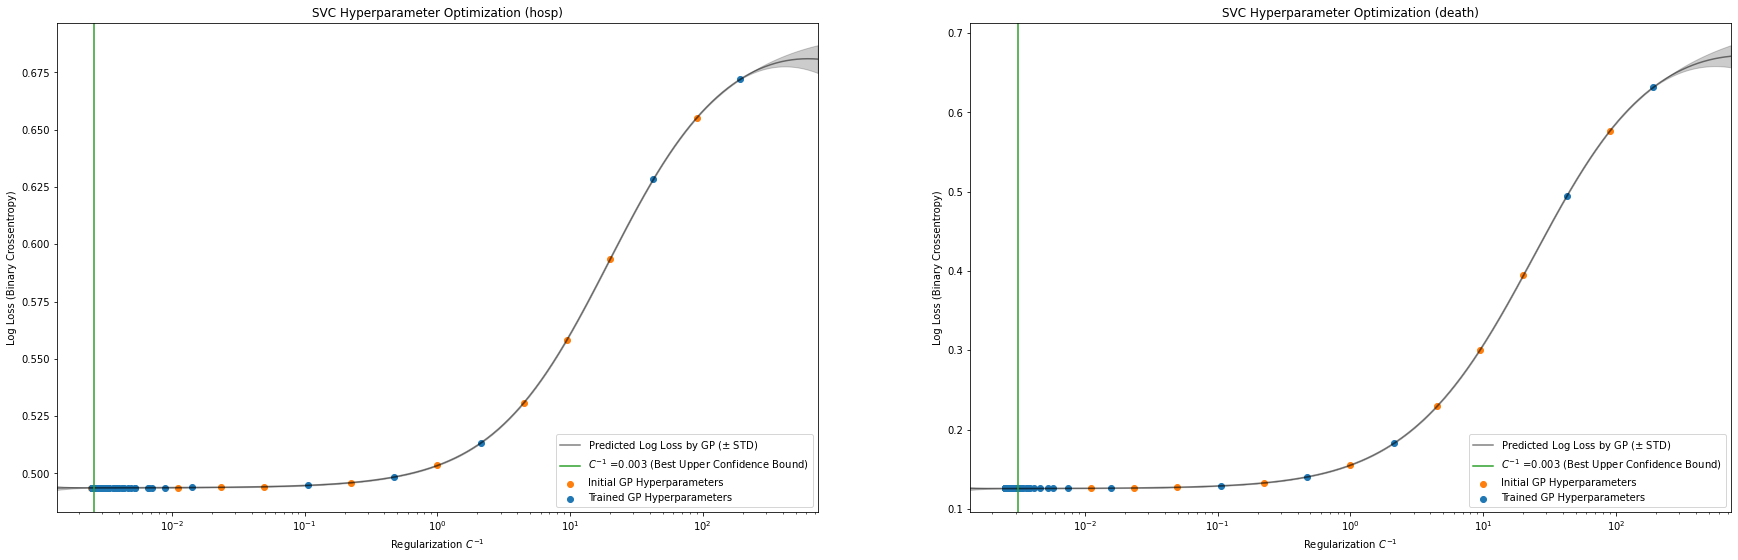

In [16]:
fig, axes = plt.subplots(1, 2, figsize=(30, 9))

for i, y_label in enumerate(['hosp', 'death']):
    axes[i].scatter(np.exp(Q[y_label][:10, 0]), E[y_label][:10, 0], color='tab:orange', label='Initial GP Hyperparameters')
    axes[i].scatter(np.exp(Q[y_label][10:, 0]), E[y_label][10:, 0], color='tab:blue', label='Trained GP Hyperparameters')

    axes[i].plot(np.exp(inverse_log_C_linspace), GP_predicted_log_loss_mean[y_label][:, 0], color='black', alpha=0.5, label=r'Predicted Log Loss by GP ($\pm$ STD)')
    axes[i].fill_between(np.exp(inverse_log_C_linspace), GP_predicted_log_loss_mean[y_label][:, 0] - GP_predicted_log_loss_std[y_label][:, 0], GP_predicted_log_loss_mean[y_label][:, 0] + GP_predicted_log_loss_std[y_label][:, 0], color='black', alpha=0.2)

    axes[i].axvline(hyperparameter_best_upper_confidence_bound[y_label]['inverse_C'], color='tab:green', label=r'$C^{-1}$ =' + f'{np.round(hyperparameter_best_upper_confidence_bound[y_label]["inverse_C"], 3)} (Best Upper Confidence Bound)')

    axes[i].set_xscale('log'); axes[i].set_xlim(np.exp(np.min(inverse_log_C_linspace)), np.exp(np.max(inverse_log_C_linspace)))
    axes[i].set_xlabel(r'Regularization $C^{-1}$'); axes[i].set_ylabel('Log Loss (Binary Crossentropy)'); axes[i].set_title(f'SVC Hyperparameter Optimization ({y_label})')
    axes[i].legend();

# Final Training

In [18]:
# scale features
sc_X_train = StandardScaler()
X_train_scaled = sc_X_train.fit_transform(X_train)

# create classifier
lr = {y_label: LogisticRegression(**LogisticRegression_parameters, C=1/hyperparameter_best_upper_confidence_bound[y_label]['inverse_C']) for y_label in ['hosp', 'death']}

# fit
for i, y_label in enumerate(['hosp', 'death']):
    lr[y_label].fit(X_train_scaled, y_train[:, i]);

# Evaluation on Test Set

In [19]:
with open('../data/data_test.pt', 'rb') as file:
    X_test, y_test = pickle.load(file)

print(f'{X_test.shape = }')
print(f'{y_test.shape = }')

X_test_scaled = sc_X_train.transform(X_test)

X_test.shape = (48160, 28)
y_test.shape = (48160, 2)


In [20]:
for i, y_label in enumerate(['hosp', 'death']):
    print(f'--- {y_label} ---')

    y_pred_proba = lr[y_label].predict_proba(X_test_scaled)
    y_pred = lr[y_label].predict(X_test_scaled)

    print(f'binary cross-entropy: {np.round(log_loss(y_test[:, i], y_pred_proba[:, 1]), 4)}')
    print(f'brier loss: {brier_score_loss(y_test[:, i], y_pred_proba[:, 1]).round(4)}')
    print(f'accuracy: {accuracy_score(y_test[:, i], y_pred).round(4)}')
    print('confusion matrix:')
    print(confusion_matrix(y_test[:, i], y_pred))
    print()

--- hosp ---
binary cross-entropy: 0.4957
brier loss: 0.1513
accuracy: 0.8742
confusion matrix:
[[40899  4563]
 [ 1495  1203]]

--- death ---
binary cross-entropy: 0.1255
brier loss: 0.0156
accuracy: 0.9948
confusion matrix:
[[47883     2]
 [  248    27]]

